In [ ]:

import numpy as np

import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

from OperationalAmplifier import BasicOperationalAmplifier



```
####################################################################################################

from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

####################################################################################################

class BasicOperationalAmplifier(SubCircuitFactory):

    __name__ = 'BasicOperationalAmplifier'
    __nodes__ = ('non_inverting_input', 'inverting_input', 'output')

    ##############################################

    def __init__(self):

        super().__init__()

        # Input impedance
        self.R('input', 'non_inverting_input', 'inverting_input', 10@u_MΩ)

        # dc gain=100k and pole1=100hz
        # unity gain = dcgain x pole1 = 10MHZ
        self.VCVS('gain', 1, self.gnd, 'non_inverting_input', 'inverting_input', voltage_gain=kilo(100))
        self.R('P1', 1, 2, 1@u_kΩ)
        self.C('P1', 2, self.gnd, 1.5915@u_uF)

        # Output buffer and resistance
        self.VCVS('buffer', 3, self.gnd, 2, self.gnd, 1)
        self.R('out', 3, 'output', 10@u_Ω)

####################################################################################################

class BasicComparator(SubCircuitFactory):

    __name__ = 'BasicComparator'
    __nodes__ = ('non_inverting_input', 'inverting_input',
                 'voltage_plus', 'voltage_minus',
                 'output')

    ##############################################

    def __init__(self,):

        super().__init__()

        # Fixme: ngspice is buggy with such subcircuit

        # Fixme: how to pass voltage_plus, voltage_minus ?
        # output_voltage_minus, output_voltage_plus = 0, 15

        # to plug the voltage source
        self.R(1, 'voltage_plus', 'voltage_minus', 1@u_MΩ)
        self.NonLinearVoltageSource(1, 'output', 'voltage_minus',
                                    expression='V(non_inverting_input, inverting_input)',
                                    # table=((-micro(1), output_voltage_minus),
                                    #       (micro(1), output_voltage_plus))
                                    table=(('-1uV', '0V'), ('1uV', '15V'))
                                )
```


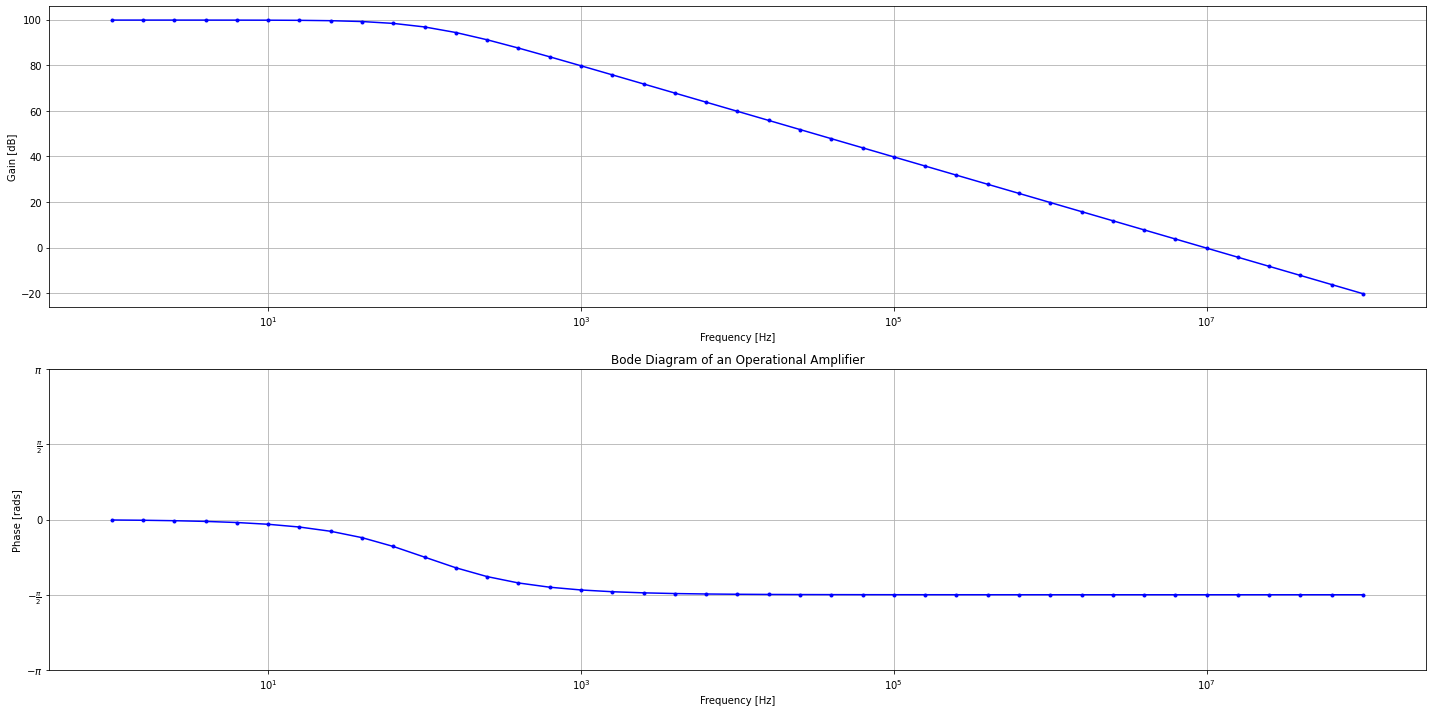

In [ ]:


circuit = Circuit('Operational Amplifier')

# AC 1 PWL(0US 0V  0.01US 1V)
circuit.SinusoidalVoltageSource('input', 'in', circuit.gnd, amplitude=1@u_V)
circuit.subcircuit(BasicOperationalAmplifier())
circuit.X('op', 'BasicOperationalAmplifier', 'in', circuit.gnd, 'out')
circuit.R('load', 'out', circuit.gnd, 470@u_Ω)

simulator = circuit.simulator(temperature=25, nominal_temperature=25)
analysis = simulator.ac(start_frequency=1@u_Hz, stop_frequency=100@u_MHz, number_of_points=5,  variation='dec')

figure, (ax1, ax2) = plt.subplots(2, figsize=(20, 10))

plt.title("Bode Diagram of an Operational Amplifier")
bode_diagram(axes=(ax1, ax2),
             frequency=analysis.frequency,
             gain=20*np.log10(np.absolute(analysis.out)),
             phase=np.angle(analysis.out, deg=False),
             marker='.',
             color='blue',
             linestyle='-',
            )
plt.tight_layout()

